# Business Understanding

Our stake holders are companies that flip houses in King County, Washington. We are using data gathered from houses sold in that area to predict whether our stake holders should invest in certain houses or not, as well as where would be the best place to locate their company.

# Data Understanding

We used data from houses that have sold in King County over the years to predict the housing prices of current homes. Using this, we can conclude whether a house is over-valued or under-valued. Based on this prediction, we can see whether it is worth it to flip a house. If a house is under-valued, then there is a good estimated profit to be made from flipping it.

# Data Preperation

### Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from utils import evaluate_model as em
from sklearn.feature_selection import RFE

### Data Frame

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Cleaning

In [4]:
df = df.loc[df['view'] == 'NONE']
df = df.drop(columns = ['yr_renovated', 'id', 'date', 'floors', 'view', 'lat', 'long', 'waterfront'])
df['grade_clean'] = df['grade'].str[:2].astype(int)
df = df.drop(columns = 'grade')
df['sqft_basement_clean'] = df['sqft_living'] - df['sqft_above']
df['has_basement'] = df['sqft_basement_clean'] > 0
df = df.drop(columns = 'sqft_basement')

map = { 
    'Poor'      :    1,  
    'Fair'      :    2,
    'Average'   :    3,
    'Good'      :    4,
    'Very Good' :    5
}
df['condition'] = df['condition'].map(map)

### Creating New Column

In [5]:
grade_group = []
for grade in df['grade_clean']:
    if grade >= 10:
        grade_group.append(2)
    elif grade <= 6:
        grade_group.append(0)
    else:
        grade_group.append(1)
        
df['grade_group'] = grade_group

### Exploratory Data Analysis

<AxesSubplot:>

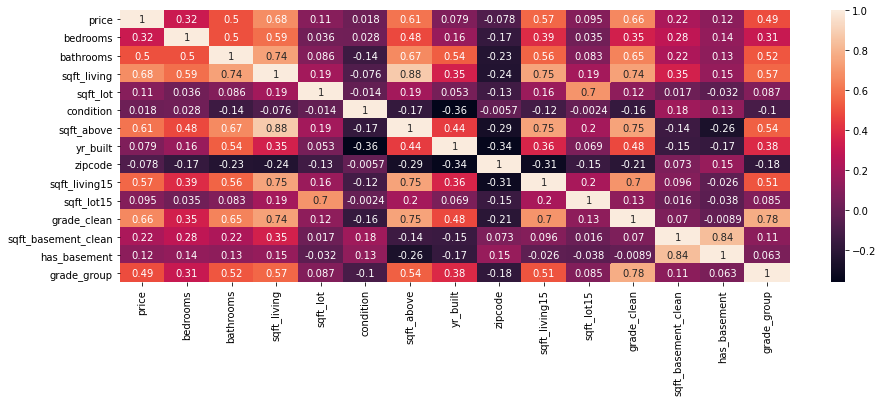

In [6]:
fig, ax = plt.subplots(figsize= (15, 5))
sns.heatmap(df.corr(), annot = True)

### Fixing Colinearity

In [7]:
df_no_co = df.copy()

In [8]:
df_no_co = df_no_co.drop(columns = ['bathrooms', 'sqft_above', 'sqft_living15', 'grade_clean'])

<AxesSubplot:>

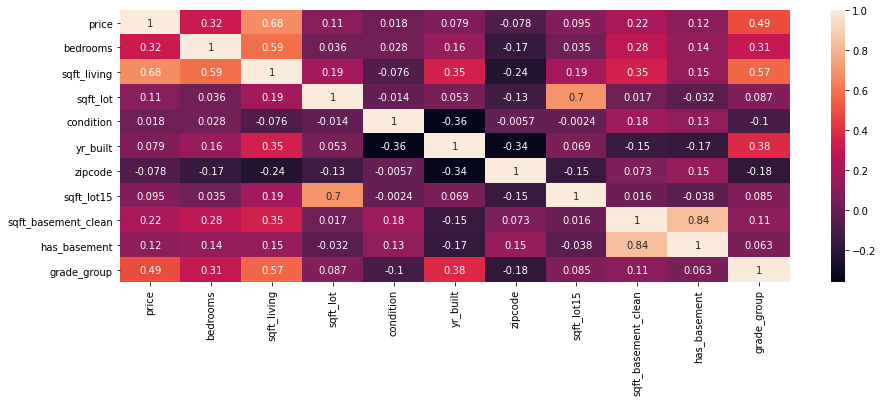

In [9]:
fig, ax = plt.subplots(figsize= (15, 5))
sns.heatmap(df_no_co.corr(), annot = True)

# Modeling

In [10]:
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.25, 
                                                    random_state=42)

In [12]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [13]:
cat_cols = ['zipcode']

encoder = OneHotEncoder(drop='first')

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough', sparse_threshold=0)

ct.fit(X_train)

X_train_enc = pd.DataFrame(ct.transform(X_train), columns=ct.get_feature_names())
X_test_enc = ct.transform(X_test)

In [14]:
X_train_enc

,ohe__x0_98002,ohe__x0_98003,ohe__x0_98004,ohe__x0_98005,ohe__x0_98006,ohe__x0_98007,ohe__x0_98008,ohe__x0_98010,ohe__x0_98011,ohe__x0_98014,...,sqft_lot,condition,sqft_above,yr_built,sqft_living15,sqft_lot15,grade_clean,sqft_basement_clean,has_basement,grade_group
0,0,0,0,0,0,0,0,0,0,0,...,8265,3,2040,1996,2160,8265,7,0,False,1
1,0,0,0,0,0,0,0,0,1,0,...,4270,3,2650,2006,2720,12523,8,510,True,1
2,0,0,0,0,0,0,0,0,0,0,...,4553,3,1950,2000,1780,4598,7,0,False,1
3,0,0,0,0,0,0,0,0,0,0,...,2970,3,990,1903,1700,3000,7,310,True,1
4,0,0,0,0,0,0,0,0,0,0,...,2731,3,1800,2014,1800,3265,8,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14561,0,1,0,0,0,0,0,0,0,0,...,7194,4,1820,1967,1420,7560,7,0,False,1
14562,0,0,0,0,0,0,0,0,0,0,...,8004,3,1330,1985,1300,7971,7,0,False,1
14563,0,0,0,0,0,0,0,0,0,0,...,3600,3,1660,1929,1970,3600,8,190,True,1
14564,0,0,0,0,0,0,0,0,0,0,...,6174,5,1520,1920,1390,5407,6,0,False,0


## Baseline Model

In [15]:
X_train_2 = X_train[['sqft_living']]
X_test_2 = X_test[['sqft_living']]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                 1.228e+04
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:42:30   Log-Likelihood:            -1.9900e+05
No. Observations:               14566   AIC:                         3.980e+05
Df Residuals:                   14564   BIC:                         3.980e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.842e+04   4463.849      8.608      

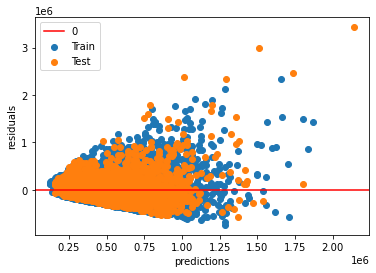

(12510    504871.206035
 6093     760960.252419
 15835    484292.621951
 14398    335669.514674
 20385    449994.981810
              ...      
 12590    454568.000495
 13333    342529.042702
 6019     461427.528523
 962      385972.720214
 17632    424843.379040
 Length: 14566, dtype: float64,
 14592    374540.173500
 20641    449994.981810
 982      251068.668994
 8289     728949.121621
 3257     276220.271763
              ...      
 1984     639775.257255
 21163    708370.537537
 18143    559747.430260
 1668     683218.934767
 16908    376826.682843
 Length: 4856, dtype: float64)

In [16]:
em(X_train_2, X_test_2, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 1.135e+04
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:42:31   Log-Likelihood:                -6051.8
No. Observations:               14566   AIC:                         1.211e+04
Df Residuals:                   14564   BIC:                         1.212e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2120      0.008   1549.054      

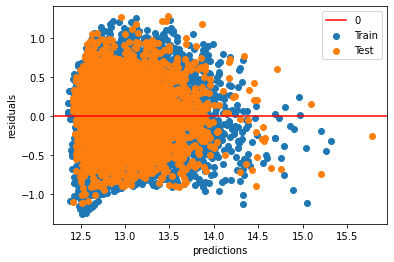

(12510    13.004007
 6093     13.438842
 15835    12.969065
 14398    12.716705
 20385    12.910828
            ...    
 12590    12.918593
 13333    12.728353
 6019     12.930240
 962      12.802119
 17632    12.868121
 Length: 14566, dtype: float64,
 14592    12.782707
 20641    12.910828
 982      12.573054
 8289     13.384487
 3257     12.615761
            ...    
 1984     13.233072
 21163    13.349545
 18143    13.097186
 1668     13.306838
 16908    12.786589
 Length: 4856, dtype: float64)

In [17]:
em(X_train_2, X_test_2, y_train_log, y_test_log)

## Kitchen Sink Model

In [18]:
X_train_3 = X_train_enc
X_test_3 = X_test_enc

In [19]:
scaler = StandardScaler()
scaler.fit(X_train_3)

X_train_3_sc = scaler.transform(X_train_3)
X_test_3_sc = scaler.transform(X_test_3)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     852.0
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:42:34   Log-Likelihood:            -1.9070e+05
No. Observations:               14566   AIC:                         3.816e+05
Df Residuals:                   14484   BIC:                         3.822e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.947e+05    977.625    506.029      0.0

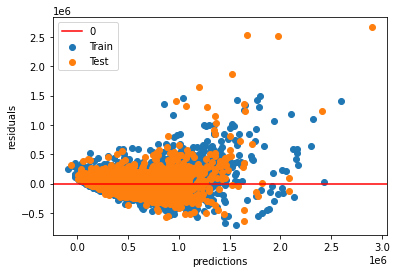

(array([381061.78746751, 625659.21868046, 347861.78746751, ...,
        945487.21868046, 247622.84822972, 638933.78746751]),
 array([361376., 473312., 427552., ..., 402912., 758976., 446928.]))

In [21]:
em(X_train_3_sc, X_test_3_sc, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1096.
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:42:35   Log-Likelihood:                 4058.6
No. Observations:               14566   AIC:                            -7953.
Df Residuals:                   14484   BIC:                            -7331.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9869      0.002   8514.124      0.0

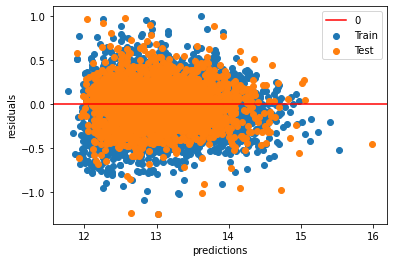

(array([12.68881796, 13.30578243, 12.73268698, ..., 13.57618915,
        12.42240262, 13.23433493]),
 array([12.8203125 , 12.96754646, 12.92449951, ..., 12.73635864,
        13.39074707, 12.95392609]))

In [22]:
em(X_train_3_sc, X_test_3_sc, y_train_log, y_test_log)

### Square Feet Against Price

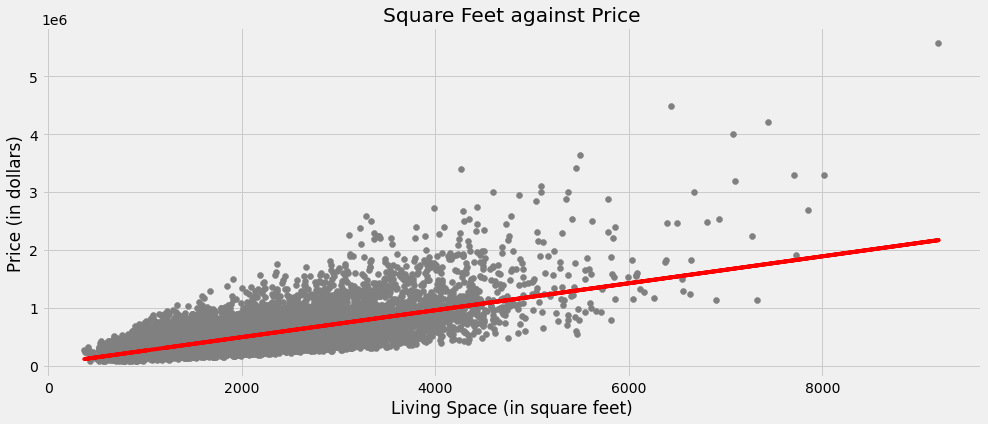

In [55]:
x = df['sqft_living']
y = df['price']
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color = 'grey')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color="Red")


plt.ylabel('Price (in dollars)')
plt.xlabel('Living Space (in square feet)')
plt.title('Square Feet against Price')
plt.show()

# Evalutation

# Limitations

# Conclusions

# Next Steps